# Abundance Clusters

In [1]:
import os
os.chdir('/root/host_home/luca')
import pandas as pd
import matplotlib.pyplot as plt


from utils import abundance

In [ ]:
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'
atlas_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'
meta_folder = '/root/host_home/luca/metadata/'
output_dir = 'nbgraphAnalysis/output/'
# The atlas with only tumor primary tissues and uicc stage annotated

cell_type_key = 'cell_type_adjusted'
sample_key = 'sample'
dataset_key = 'dataset'

## I-II Leiden Wu

Get the relative abundance of cell type per sample

In [3]:
time = 'I-II_leidenwu_funcnames'
time_solo = time.split('_')[0]
time_suffix = 'early' if time_solo == 'I-II' else 'late'

# Unstack the group counts
groups = pd.read_csv(f'{meta_folder}/groups_{time}.csv', index_col=0)
groups.sort_values([cell_type_key, sample_key])
groups.set_index([cell_type_key,sample_key], inplace=True)
cutoff = groups.loc[:, '0']
# We dont remove the cutoff because it messes with the dims
cutoff = pd.DataFrame(cutoff[cutoff > 1])
samp_type = cutoff.unstack().transpose()

# Normalize the counts
samp_type = samp_type.fillna(0)
corr_types = (samp_type.T / samp_type.T.sum()).T

groups.reset_index(inplace=True)
group_dataset = groups.groupby(['sample','dataset']).sum()
group_dataset.reset_index(inplace=True)
corr_types = pd.merge(corr_types, group_dataset.loc[:,[sample_key,'dataset']], how='left', left_on=sample_key, right_on=sample_key)
corr_types.set_index(sample_key, inplace=True)

print(f'Size of Corr_types: {corr_types.shape}')

Size of Corr_types: (122, 51)


### Box plot general

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


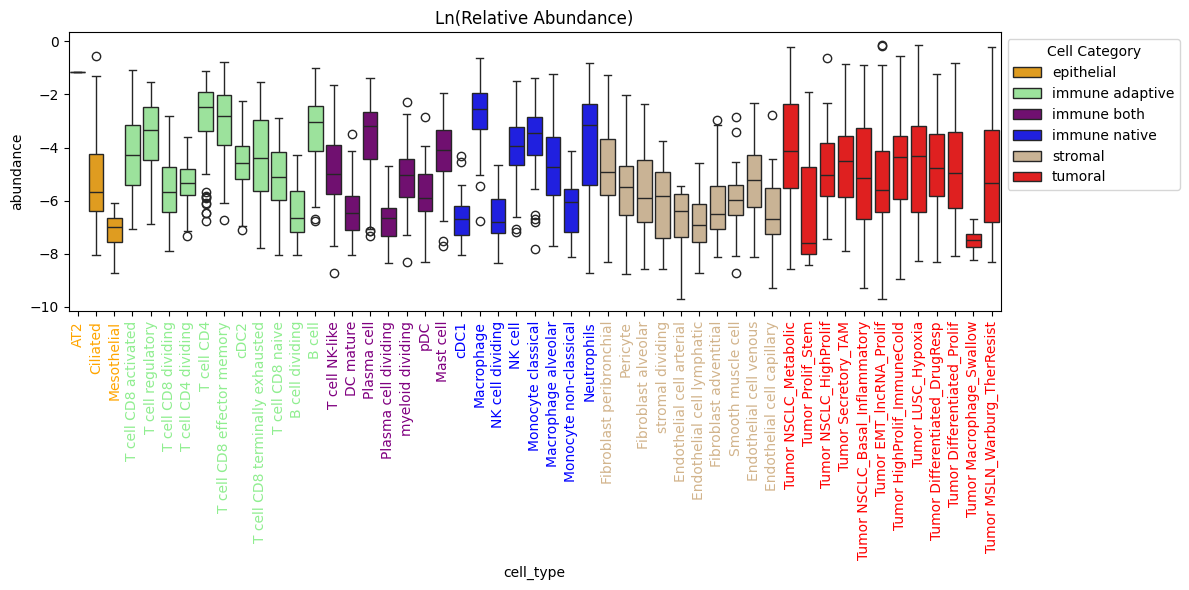

In [ ]:
category_map = abundance.cell_category_mapping
abundance.plot_celltype_boxplot(corr_types.drop(columns=['dataset']), category_map, abundance.color_map)

### Calculate clusters

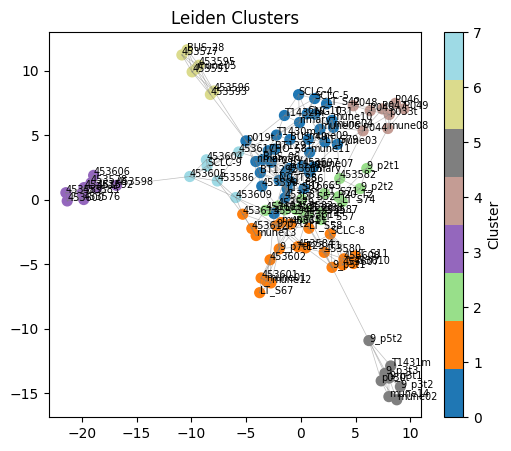

In [ ]:
g = abundance.cluster_samples_leiden(corr_types, k=4, res=0.5)

# Create a mapping from sample name to membership
membership_map = {v["name"]: v["membership"] for v in g.vs}

# Add the membership column to corr_types_III
corr_types["membership"] = corr_types.index.map(membership_map)
corr_types.head()

# df_short = corr_types[['dataset', 'membership']].sort_values('membership')
# df_short.to_csv(f'{output_dir}/membership_by_cluster_{time_suffix}.csv')
# df_short

In [ ]:
########### IMPORT ###################
df_short = pd.read_csv(f'{output_dir}/membership_by_cluster_{time_suffix}.csv', index_col=0)
corr_types = pd.merge(corr_types, df_short['membership'], how='left', right_index=True, left_index=True)

### Abundance Heatmap

/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


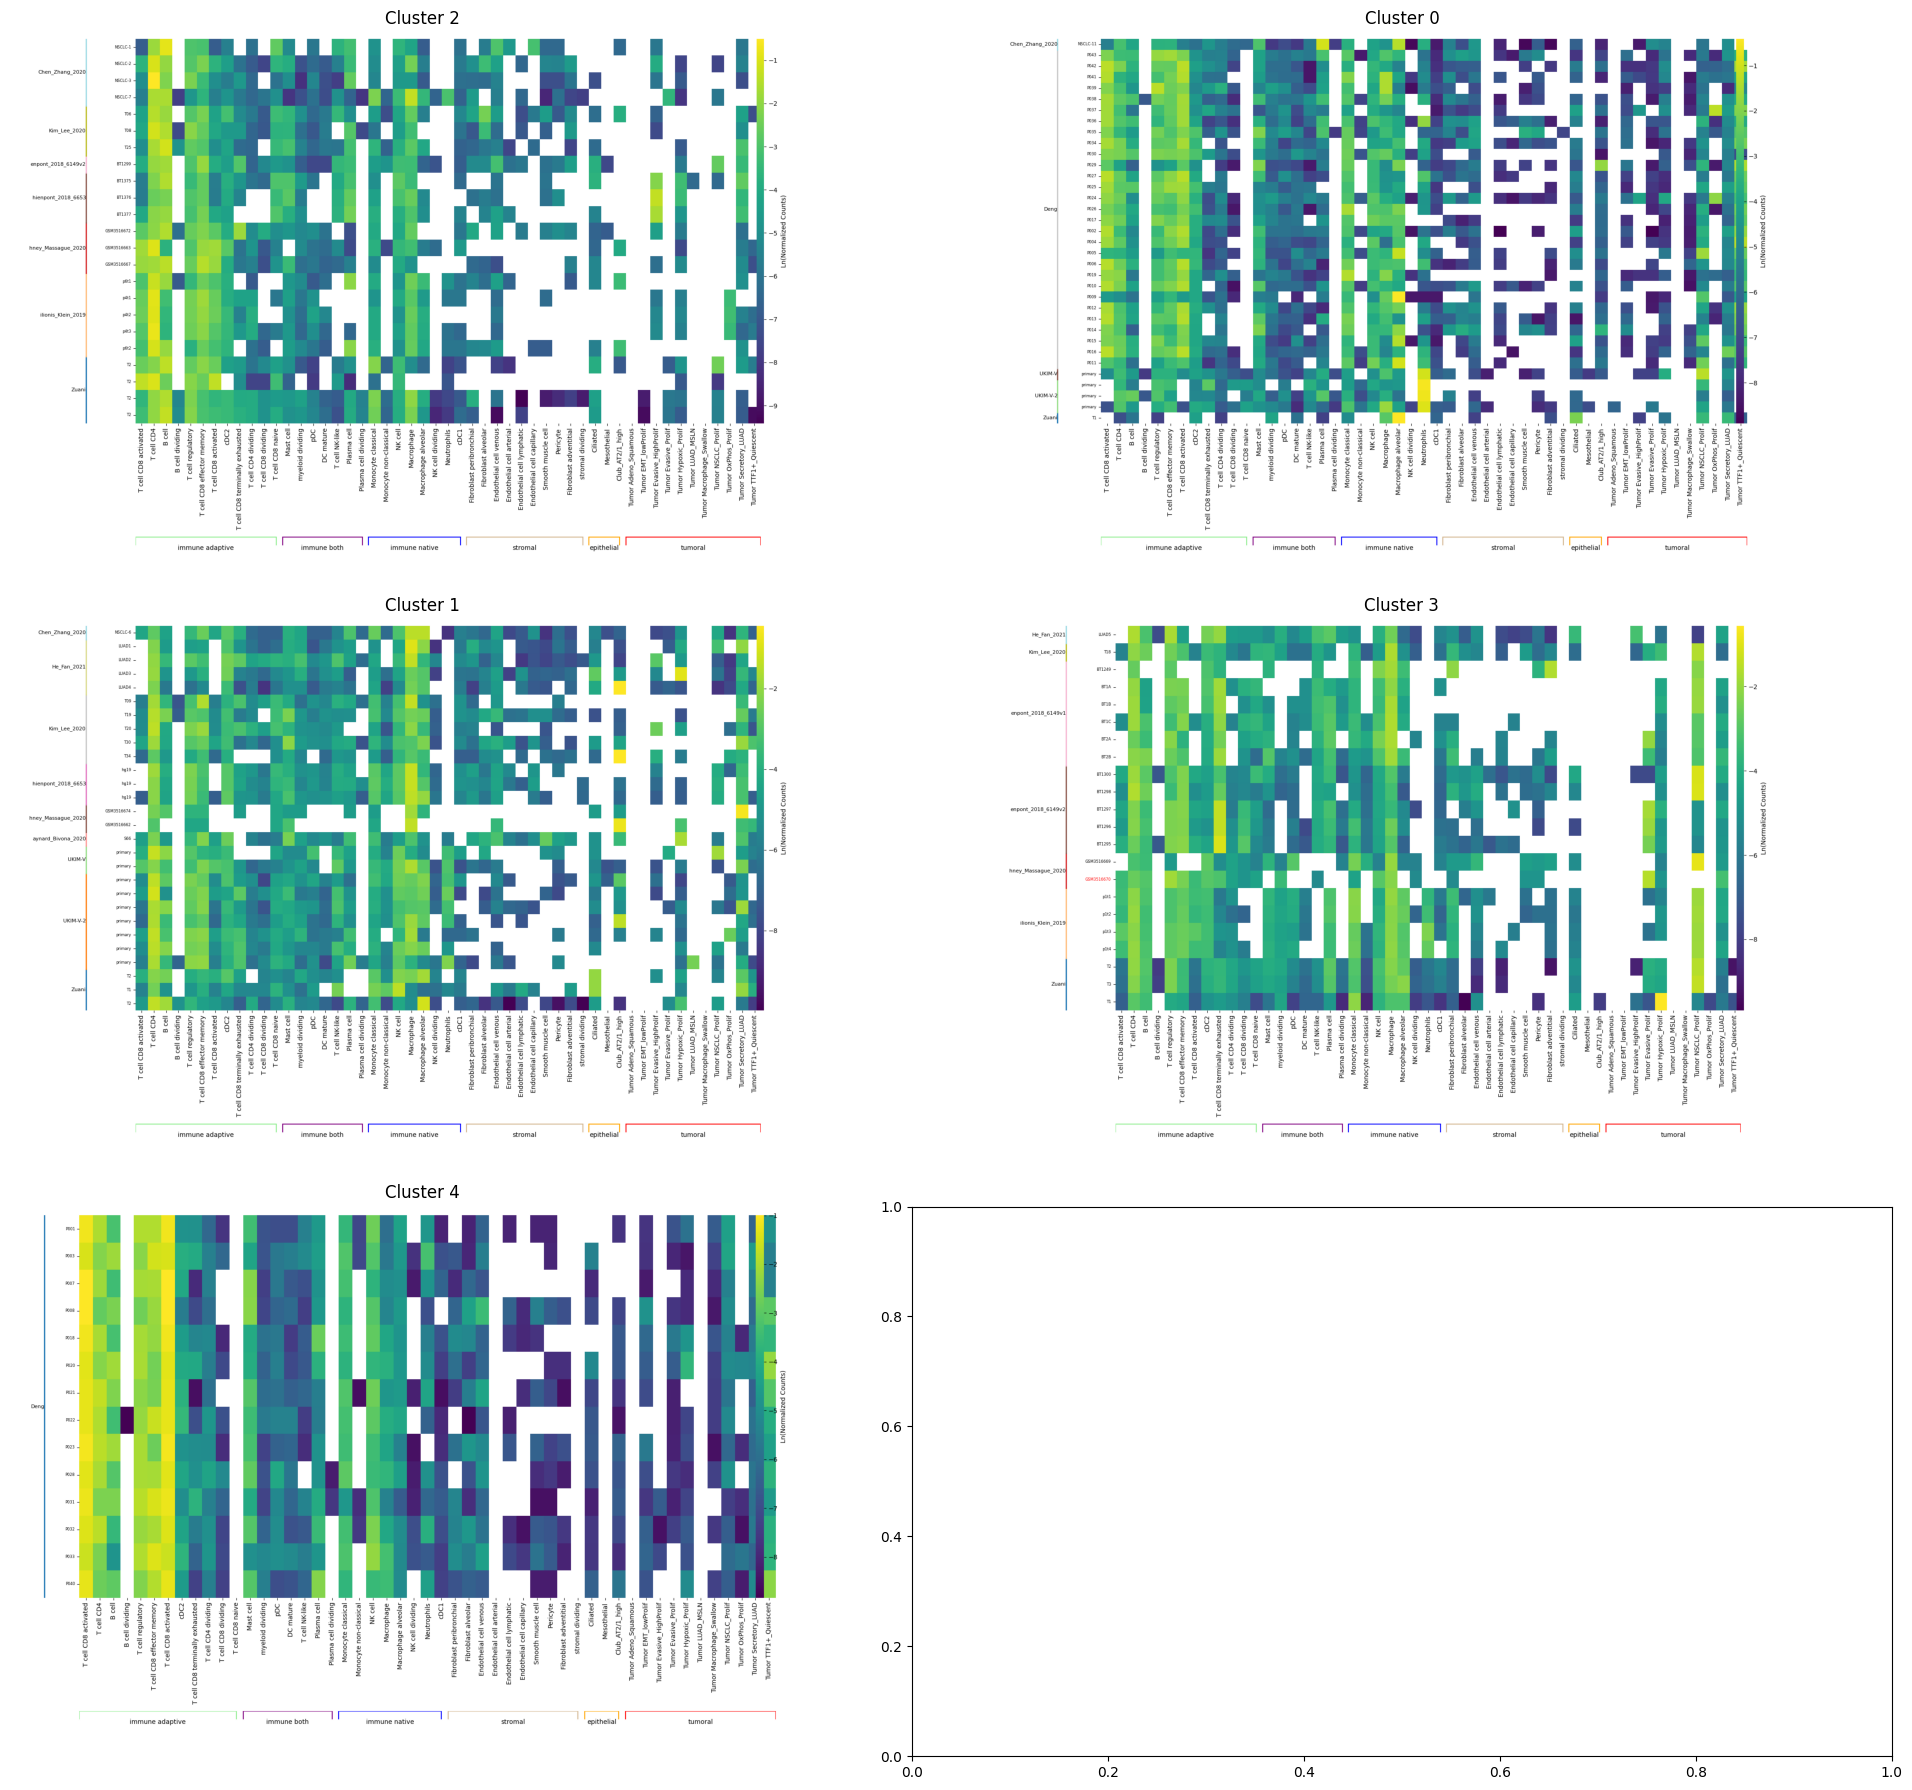

In [140]:
import io
from PIL import Image

unique_clusters = corr_types["membership"].unique()
ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 6*nrows))
# fig.subplots_adjust(wspace=0.002, hspace=0.02)

for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id].drop(columns="membership")
    temp_fig = abundance.plot_abundance_heatmap(subset, show_plot=False)

    # Convert the figure to an image
    buf = io.BytesIO()
    temp_fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)

    # Show the image in a grid cell
    ax = axes[i // ncols, i % ncols]
    ax.imshow(img)
    ax.set_title(f"Cluster {cluster_id}")
    ax.axis('off')

    plt.close(temp_fig)  # Close the temporary figure to avoid overlap

plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)
plt.show()


### Cluster boxplots

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/host_home/luca/utils/abundance.py:470: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/host_home/luca/utils/abundance.py:470: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/host_home/luca/ut

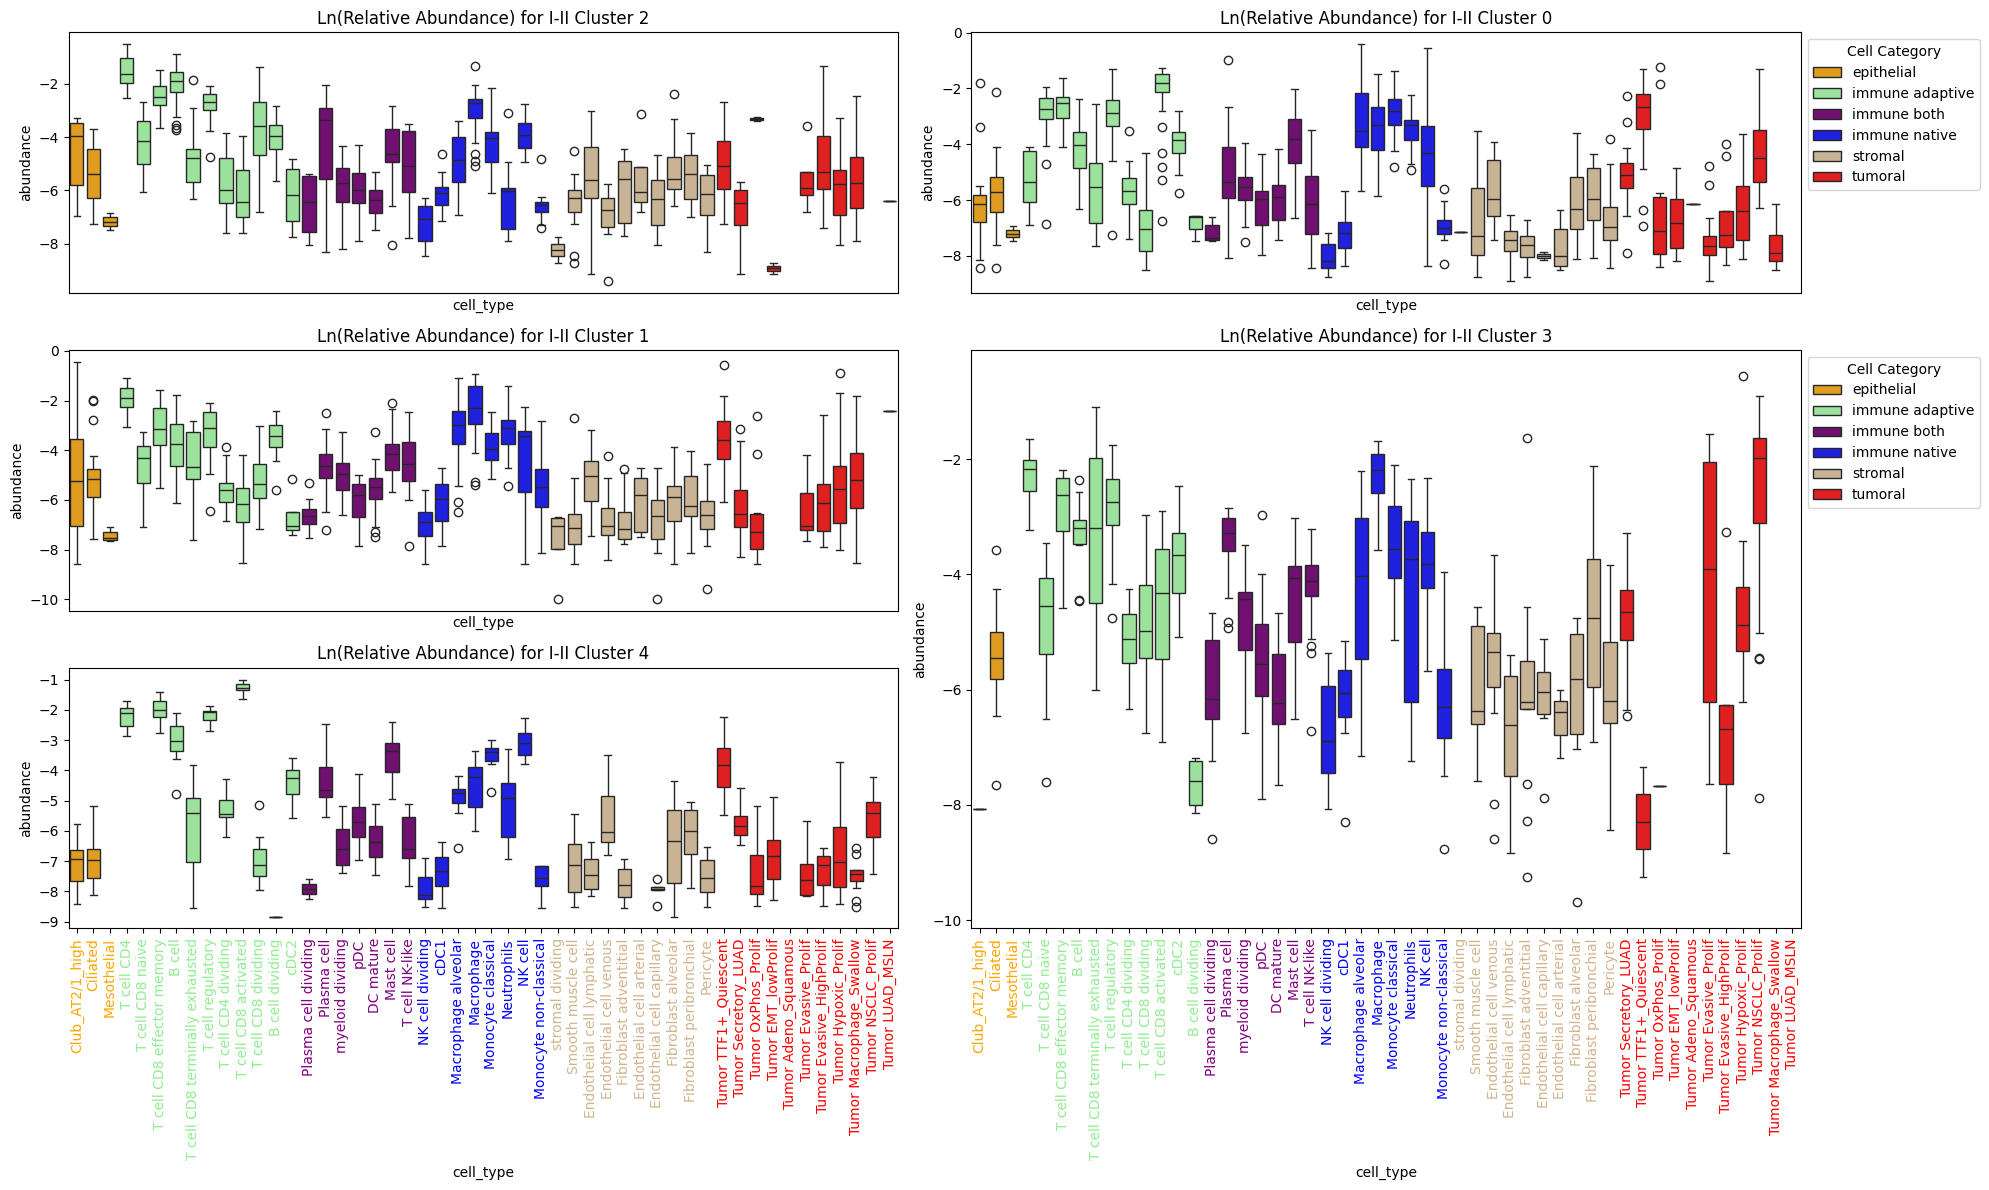

In [ ]:
category_map = abundance.cell_category_mapping

unique_clusters = corr_types["membership"].unique()

ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
is_unpair = len(unique_clusters) % ncols == 1
nrows2 = nrows -1 if is_unpair else nrows
fig = plt.figure(figsize=(20, 4*nrows))


for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id].drop(columns="membership")    
    
    rs = 2 if is_unpair and i == len(unique_clusters) - 2 else 1
    ax = plt.subplot2grid((nrows, ncols), (i // ncols, i % ncols), rowspan=rs)

    abundance.plot_celltype_boxplot(subset.drop(columns=['dataset']),title=f"for {time_solo} Cluster {cluster_id}",
                                     category_map=category_map, cat_colors=abundance.color_map, ax=ax)
    
    if i != 1:
        ax.get_legend().remove()

    if i // ncols != nrows - 1:
        if is_unpair and i == len(unique_clusters) - 2:
            continue
        
        ax.set_xticks([])
        ax.set_xticklabels([])


plt.tight_layout()
plt.show()

### pEARSON GRAPHS

In [5]:
Gs = {}

/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])


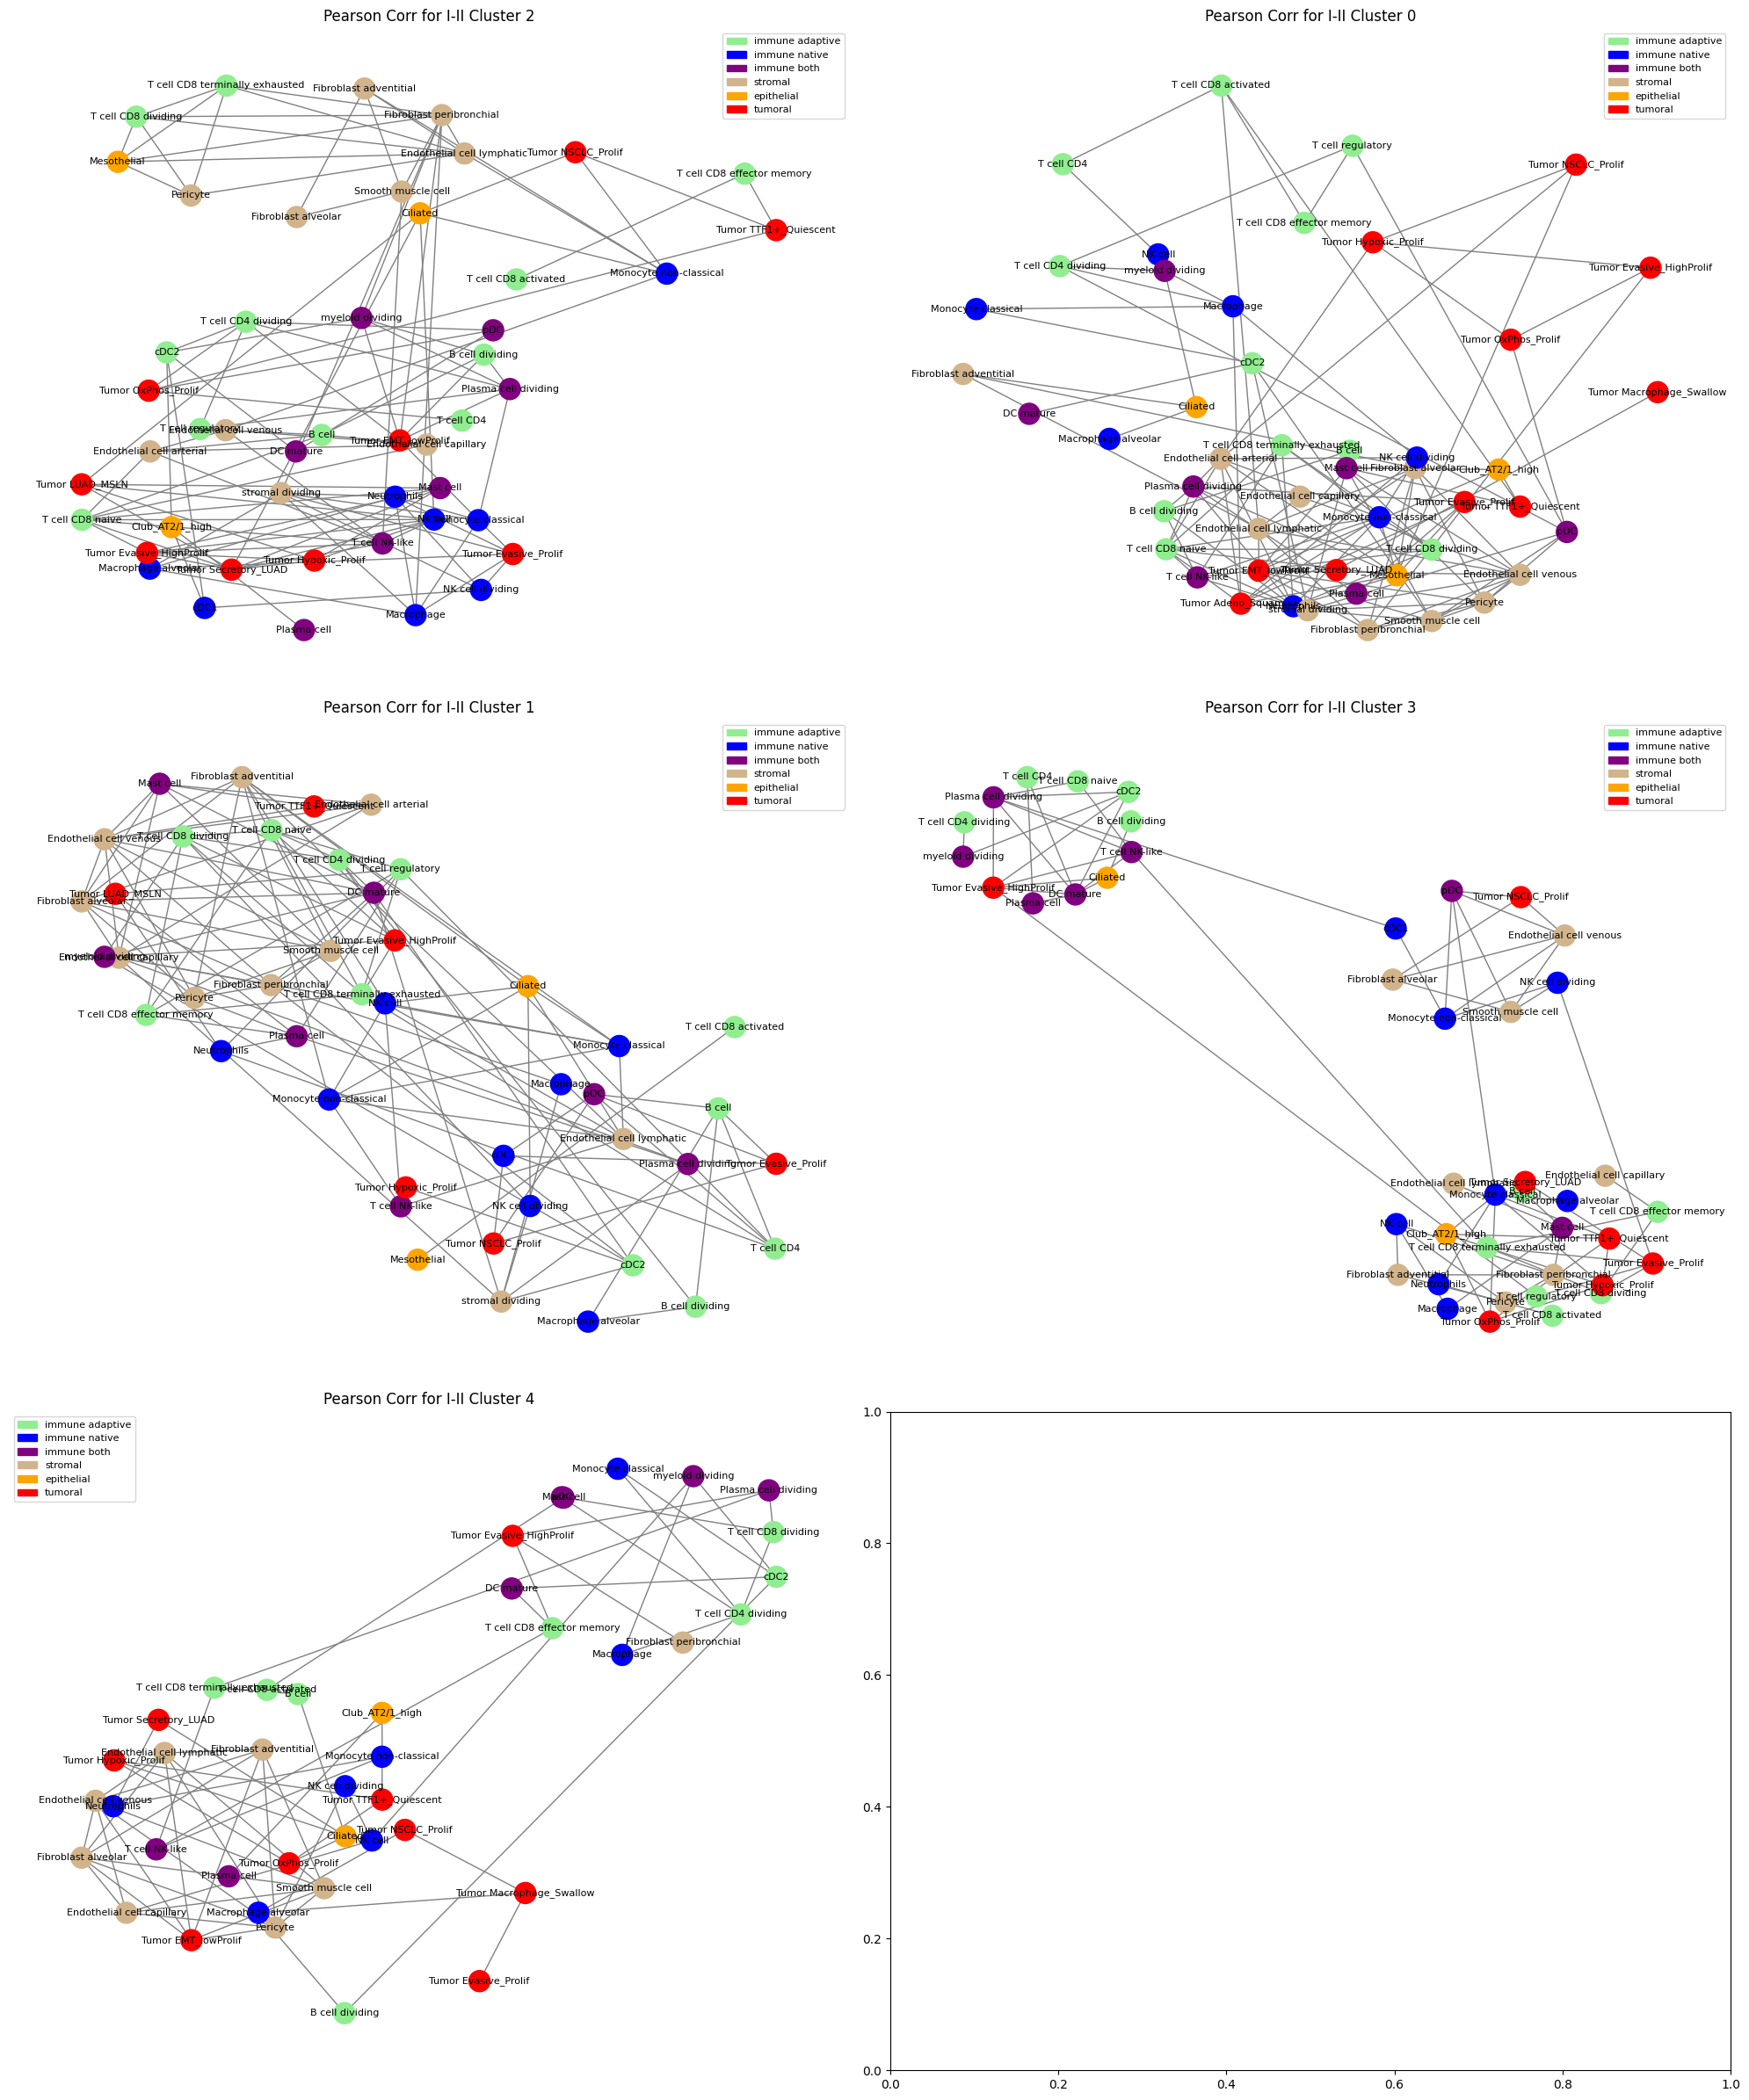

In [ ]:
unique_clusters = corr_types["membership"].unique()
ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8*nrows))

for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id]#.drop(columns="membership")

    rs = 2 if is_unpair and i == len(unique_clusters) - 2 else 1
    ax = plt.subplot2grid((nrows, ncols), (i // ncols, i % ncols), rowspan=rs)

    if cluster_id not in Gs.keys():        
        G = abundance.draw_pearson_graphs(subset, title=time, draw=False)
        Gs[cluster_id] = G
    else:
        G = Gs[cluster_id]

    
    abundance.draw_graph(G, ax, f'Pearson Corr for {time_solo} Cluster {cluster_id}', scale2=7)

plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)
plt.show()


### dEGREE CENTRAL

/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:293: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])


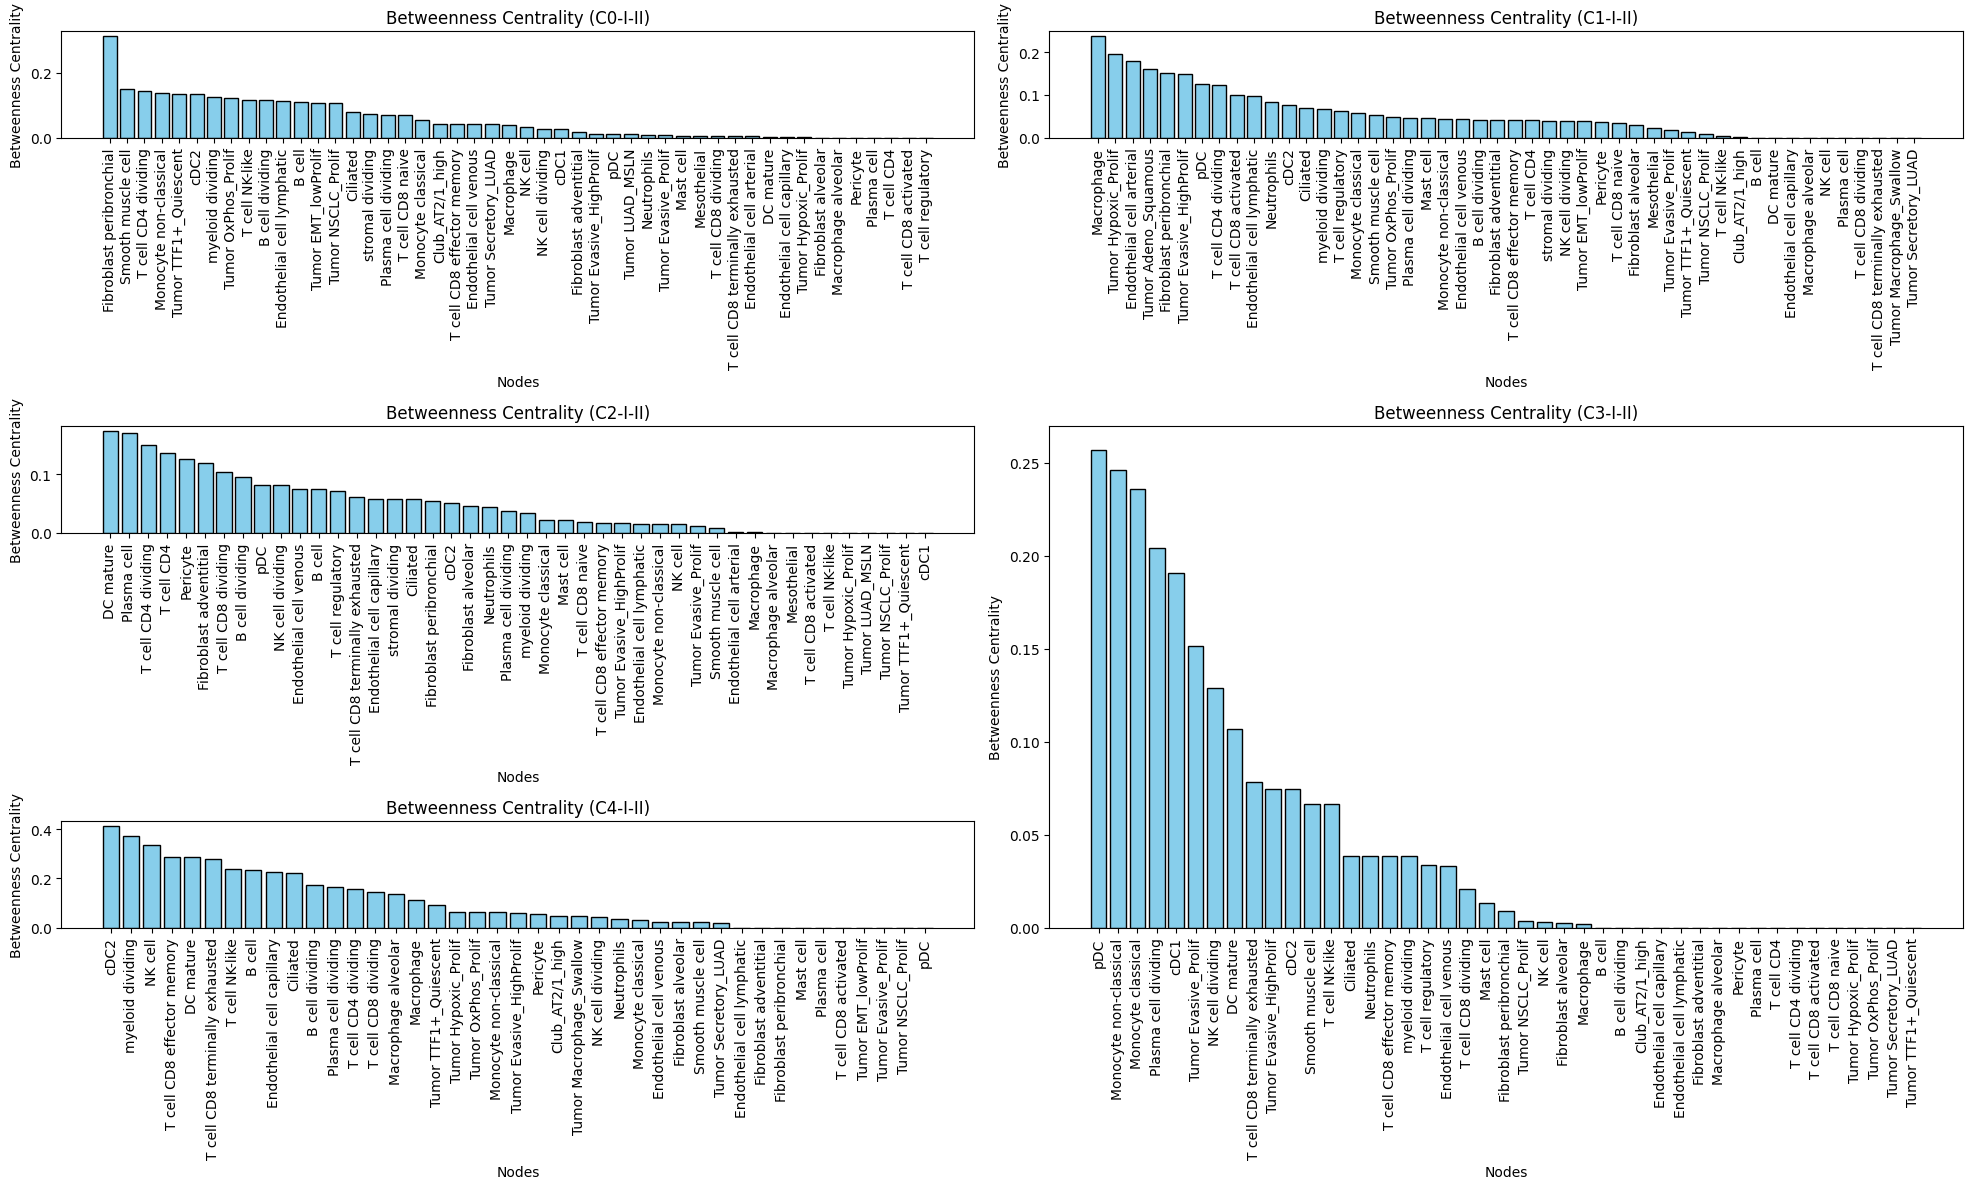

In [15]:
category_map = abundance.cell_category_mapping

unique_clusters = corr_types["membership"].unique()

ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
is_unpair = len(unique_clusters) % ncols == 1
nrows2 = nrows -1 if is_unpair else nrows
fig = plt.figure(figsize=(20, 4*nrows))

for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id].drop(columns="membership")    
    
    rs = 2 if is_unpair and i == len(unique_clusters) - 2 else 1
    ax = plt.subplot2grid((nrows, ncols), (i // ncols, i % ncols), rowspan=rs)

    if cluster_id not in Gs.keys():        
        G = abundance.draw_pearson_graphs(subset, title=time, draw=False)
        Gs[cluster_id] = G
    else:
        G = Gs[cluster_id]

    abundance.plot_degree_centrality(G, time=f'C{i}-{time_solo}', ax=ax,
                                      betweenness=True
                                      )

    # if i != 1:
    #     ax.get_legend().remove()

    # if i // ncols != nrows - 1:
    #     if is_unpair and i == len(unique_clusters) - 2:
    #         continue        
    #     ax.set_xticks([])
    #     ax.set_xticklabels([])

plt.tight_layout()
plt.show()

### Sankey Plot

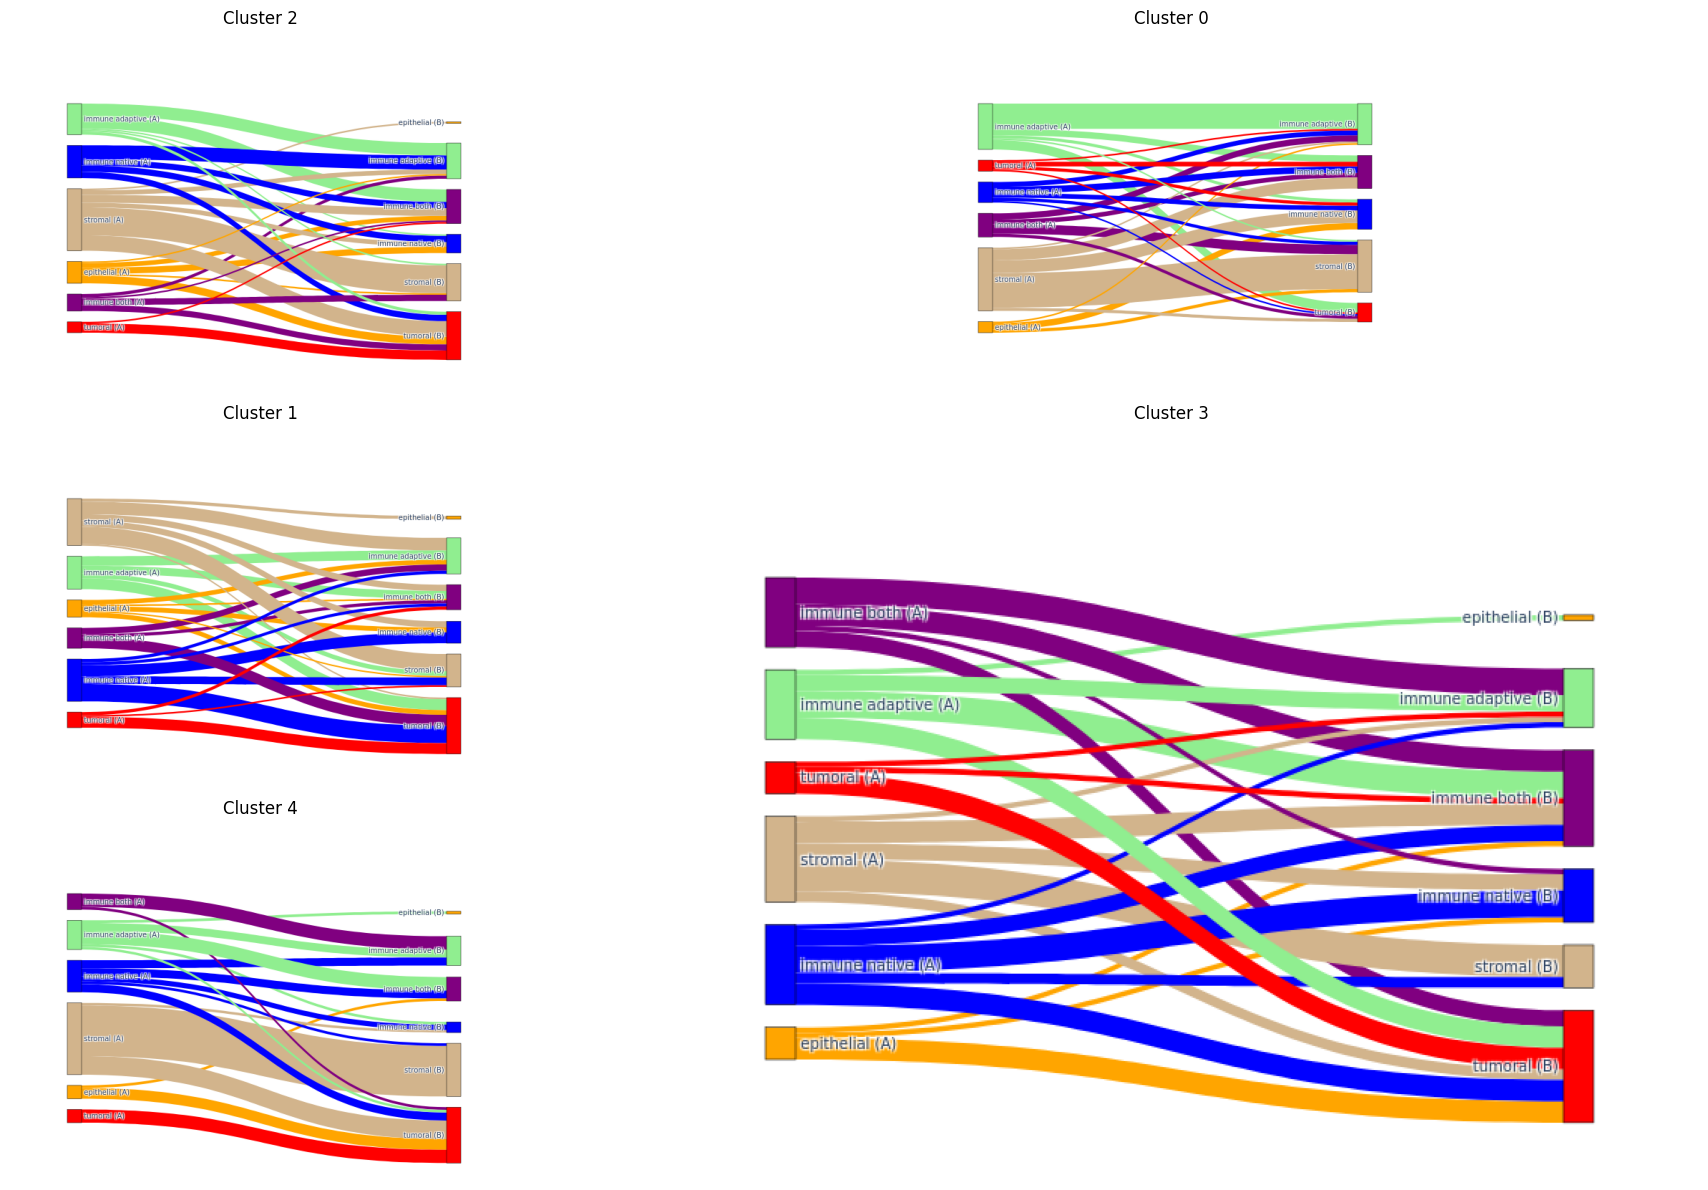

In [24]:
import io
from PIL import Image

unique_clusters = corr_types["membership"].unique()
ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
is_unpair = len(unique_clusters) % ncols == 1
nrows2 = nrows -1 if is_unpair else nrows
fig = plt.figure(figsize=(20, 4*nrows))

for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id].drop(columns="membership")

    if cluster_id not in Gs.keys():        
        G = abundance.draw_pearson_graphs(subset, title=time, draw=False)
        Gs[cluster_id] = G
    else:
        G = Gs[cluster_id]

    temp_fig = abundance.make_sankey_plot(Gs[i], abundance.cell_category_mapping, abundance.color_map)

    # Convert the figure to an image
    buf = io.BytesIO()
    temp_fig.write_image(buf,format="png")
    # temp_fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)

    rs = 2 if is_unpair and i == len(unique_clusters) - 2 else 1
    ax = plt.subplot2grid((nrows, ncols), (i // ncols, i % ncols), rowspan=rs)

    ax.imshow(img)
    ax.set_title(f"Cluster {cluster_id}")
    ax.axis('off')


plt.tight_layout()
plt.show()

### Abundance Heatmap

In [ ]:
import io
from PIL import Image

unique_clusters = corr_types["membership"].unique()
ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 6*nrows))
# fig.subplots_adjust(wspace=0.002, hspace=0.02)

for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id].drop(columns="membership")
    temp_fig = abundance.plot_abundance_heatmap(subset, show_plot=False)

    # Convert the figure to an image
    buf = io.BytesIO()
    temp_fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)

    # Show the image in a grid cell
    ax = axes[i // ncols, i % ncols]
    ax.imshow(img)
    ax.set_title(f"Cluster {cluster_id}")
    ax.axis('off')

    plt.close(temp_fig)  # Close the temporary figure to avoid overlap

plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)
plt.show()


## III-IV Leiden Wu

Get the relative abundance of cell type per sample

In [25]:
time = 'III-IV_leidenwu_funcnames'
time_solo = time.split('_')[0]
time_suffix = 'early' if time_solo == 'I-II' else 'late'

# Unstack the group counts
groups = pd.read_csv(f'{meta_folder}/groups_{time}.csv', index_col=0)
groups.sort_values([cell_type_key, sample_key])
groups.set_index([cell_type_key,sample_key], inplace=True)
cutoff = groups.loc[:, '0']
# We dont remove the cutoff because it messes with the dims
cutoff = pd.DataFrame(cutoff[cutoff > 1])
samp_type = cutoff.unstack().transpose()

# Normalize the counts
samp_type = samp_type.fillna(0)
corr_types = (samp_type.T / samp_type.T.sum()).T

groups.reset_index(inplace=True)
group_dataset = groups.groupby(['sample','dataset']).sum()
group_dataset.reset_index(inplace=True)
corr_types = pd.merge(corr_types, group_dataset.loc[:,[sample_key,'dataset']], how='left', left_on=sample_key, right_on=sample_key)
corr_types.set_index(sample_key, inplace=True)

print(f'Size of Corr_types: {corr_types.shape}')

Size of Corr_types: (111, 52)


/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


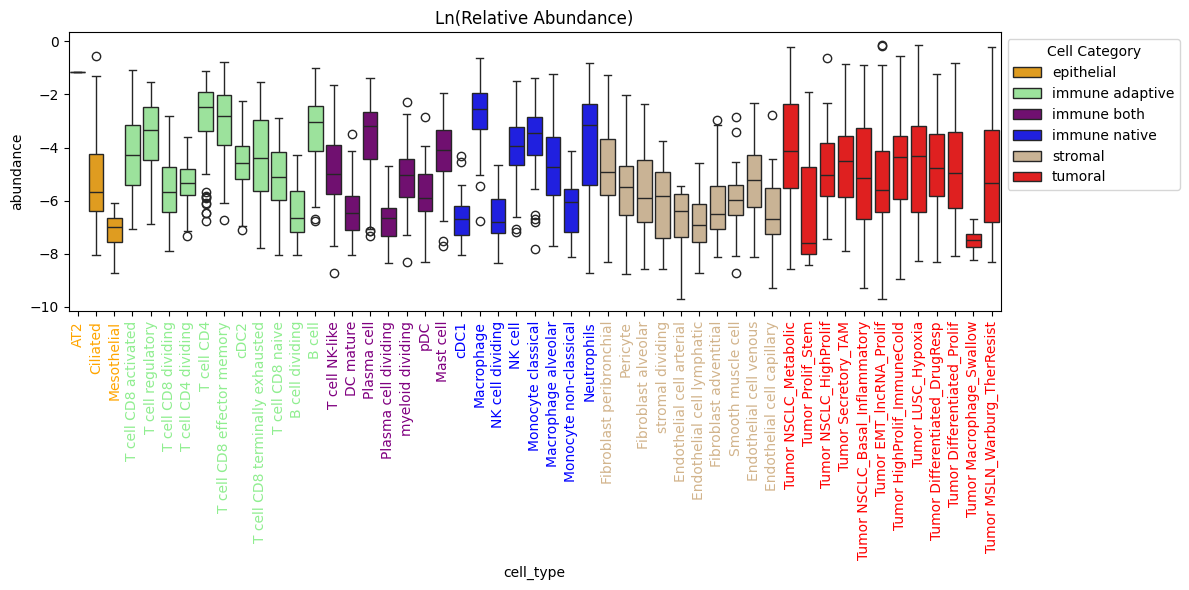

In [257]:
category_map = abundance.cell_category_mapping
abundance.plot_celltype_boxplot(corr_types.drop(columns=['dataset']), category_map, abundance.color_map)

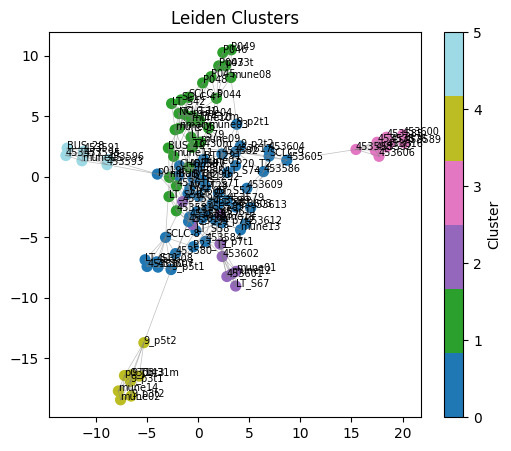

In [ ]:
g = abundance.cluster_samples_leiden(corr_types, k=4, res=0.4)

# Create a mapping from sample name to membership
membership_map = {v["name"]: v["membership"] for v in g.vs}

# Add the membership column to corr_types_III
corr_types["membership"] = corr_types.index.map(membership_map)
corr_types.head()

In [26]:
# df_short = corr_types[['dataset', 'membership']].sort_values('membership')
# df_short.to_csv(f'membership_by_cluster_{time_suffix}.csv')
# df_short

df_short = pd.read_csv(f'membership_by_cluster_{time_suffix}.csv', index_col=0)
corr_types = pd.merge(corr_types, df_short['membership'], how='left', right_index=True, left_index=True)

### Abundance Heatmap

/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


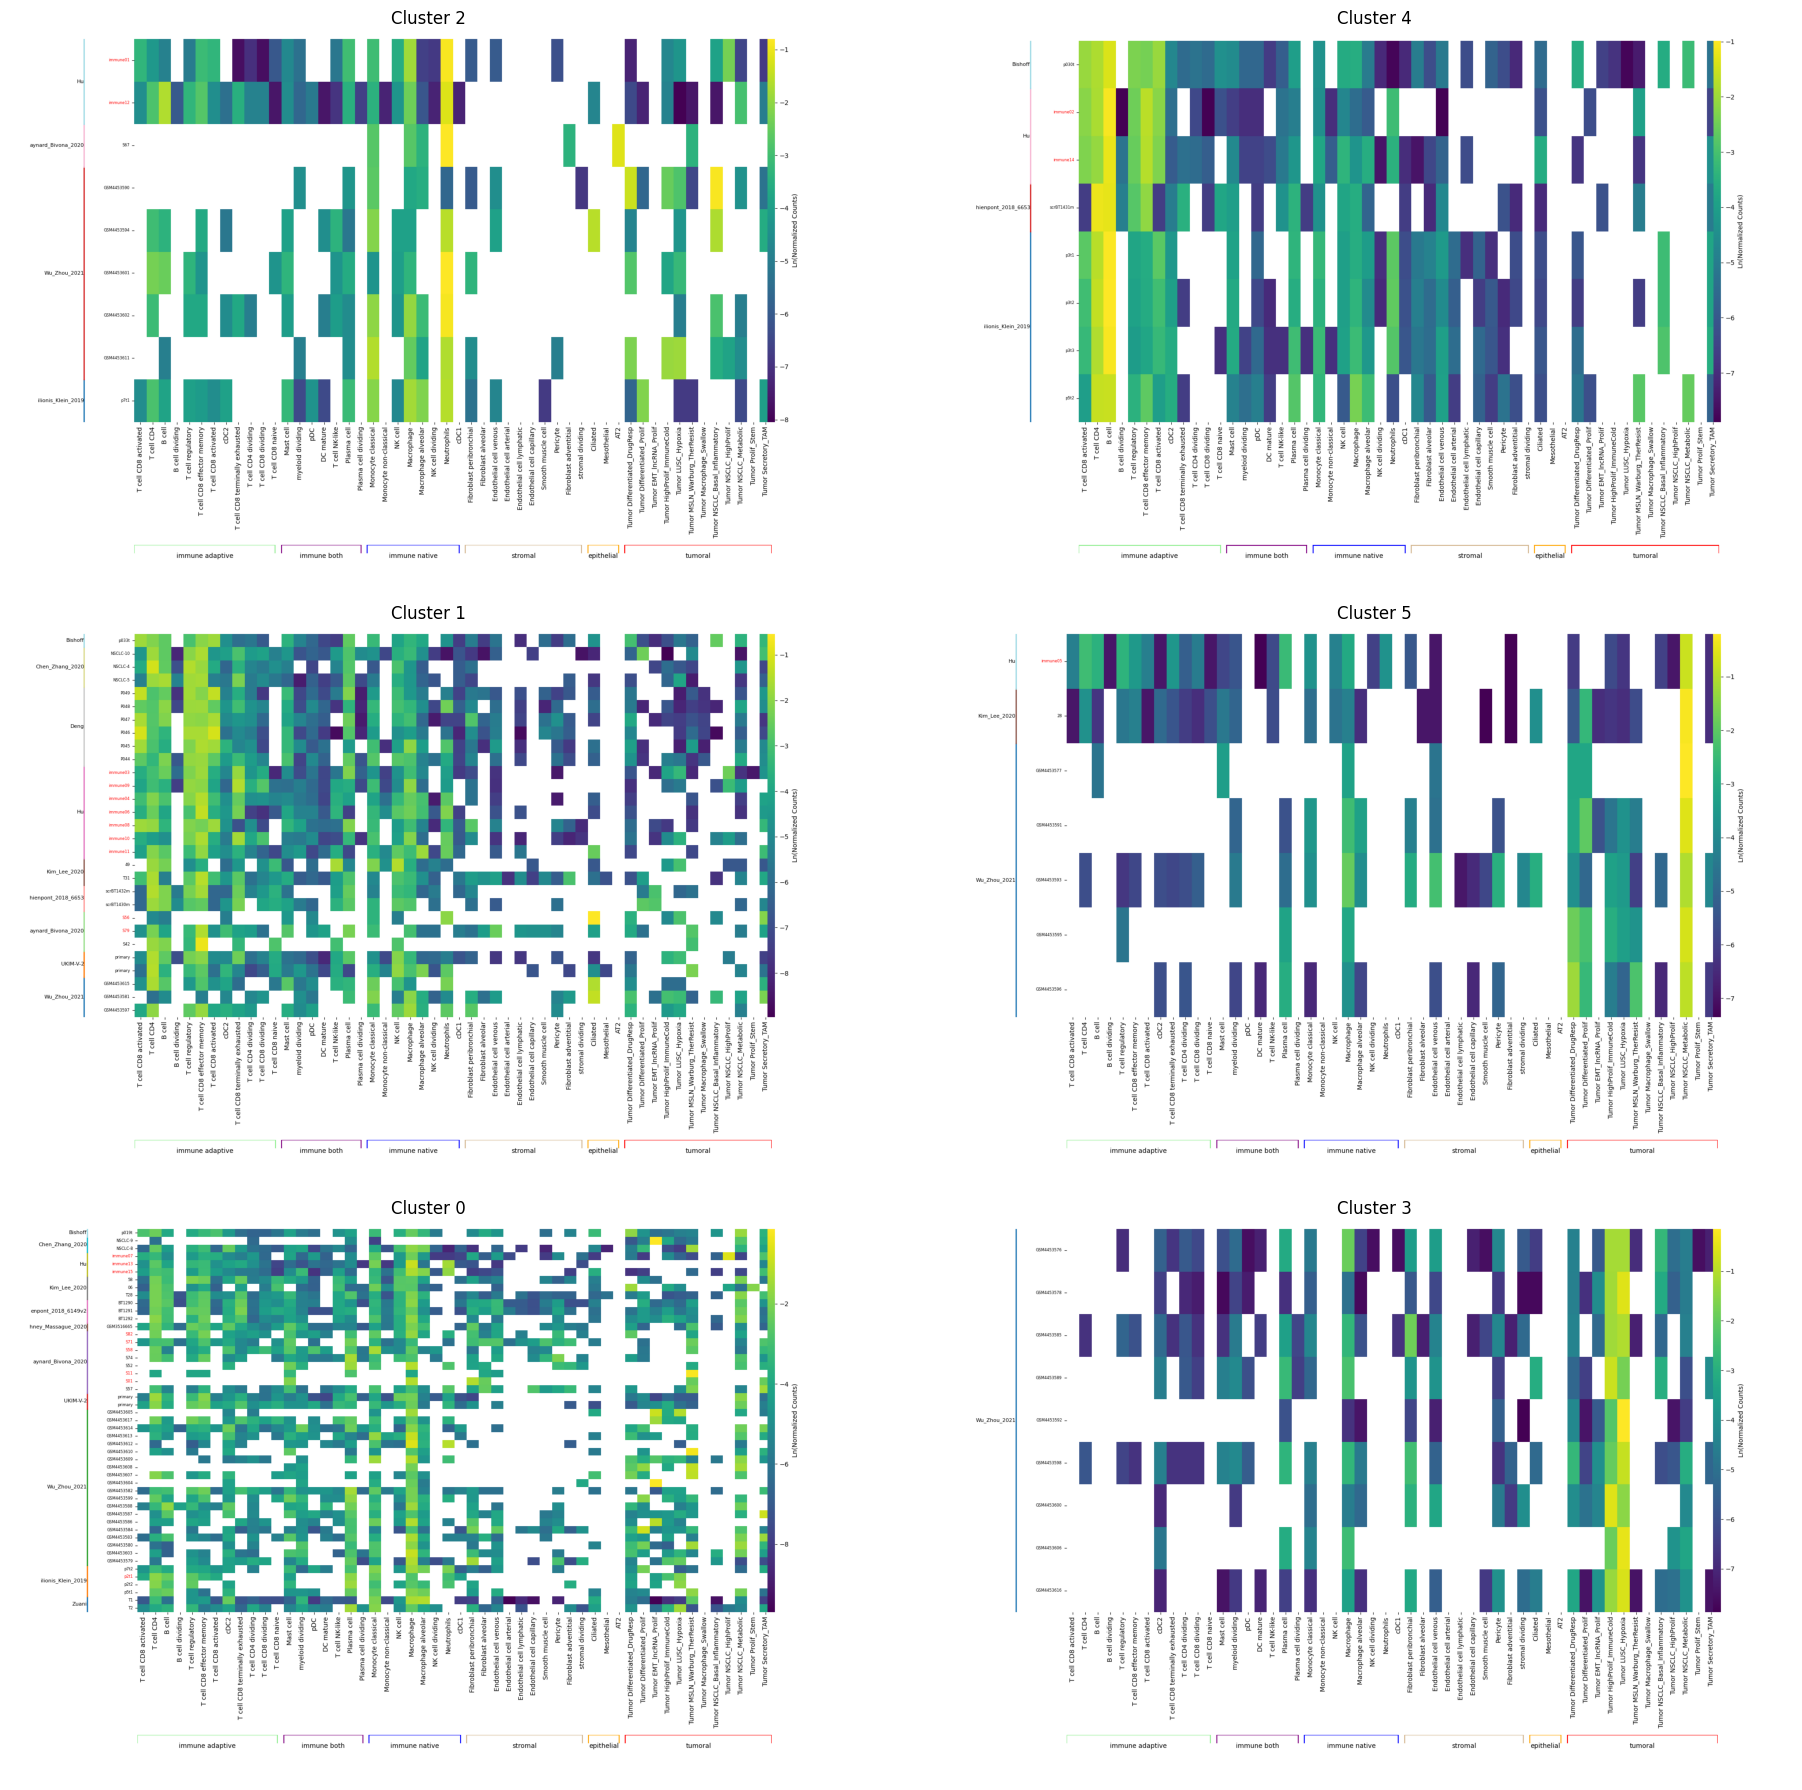

In [116]:
import io
from PIL import Image

unique_clusters = corr_types["membership"].unique()
ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 6*nrows))
# fig.subplots_adjust(wspace=0.002, hspace=0.02)

for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id].drop(columns="membership")
    temp_fig = abundance.plot_abundance_heatmap(subset, show_plot=False)

    # Convert the figure to an image
    buf = io.BytesIO()
    temp_fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)

    # Show the image in a grid cell
    ax = axes[i // ncols, i % ncols]
    ax.imshow(img)
    ax.set_title(f"Cluster {cluster_id}")
    ax.axis('off')

    plt.close(temp_fig)  # Close the temporary figure to avoid overlap

plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)
plt.show()


### Cluster boxplots

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/host_home/luca/utils/abundance.py:470: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/host_home/luca/utils/abundance.py:470: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/host_home/luca/ut

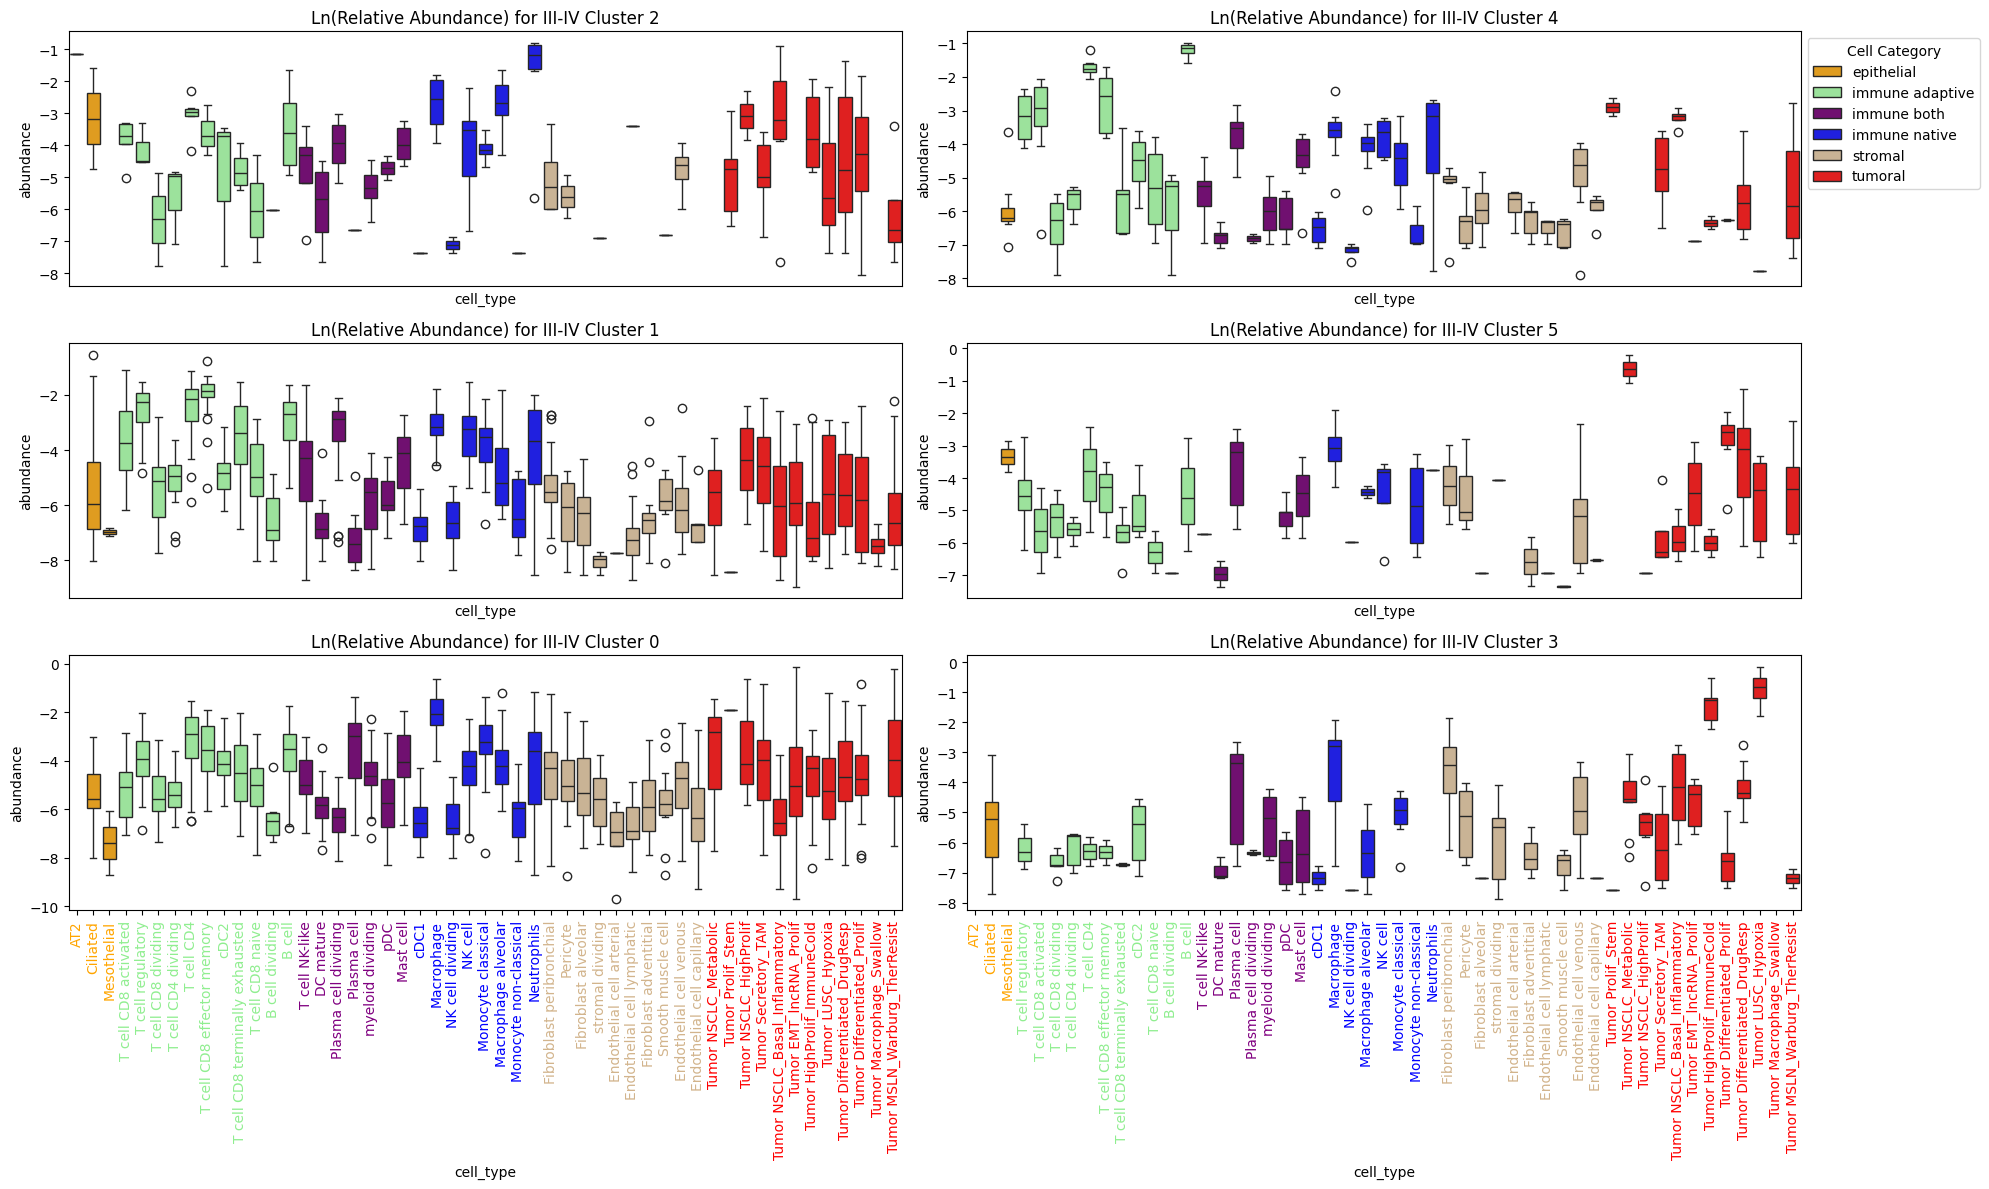

In [ ]:
category_map = abundance.cell_category_mapping

unique_clusters = corr_types["membership"].unique()

ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
is_unpair = len(unique_clusters) % ncols == 1
nrows2 = nrows -1 if is_unpair else nrows
fig = plt.figure(figsize=(20, 4*nrows))


for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id].drop(columns="membership")    
    
    rs = 2 if is_unpair and i == len(unique_clusters) - 2 else 1
    ax = plt.subplot2grid((nrows, ncols), (i // ncols, i % ncols), rowspan=rs)

    abundance.plot_celltype_boxplot(subset.drop(columns=['dataset']),title=f"for {time_solo} Cluster {cluster_id}",
                                     category_map=category_map, cat_colors=abundance.color_map, ax=ax)
    
    if i // ncols != nrows - 1:
        if is_unpair and i == len(unique_clusters) - 2:
            continue
        
        ax.set_xticks([])
        ax.set_xticklabels([])        
        
    if i != 1:
        ax.get_legend().remove()


plt.tight_layout()
plt.show()

### Coabundance graphs

In [55]:
Gs = {}

/root/host_home/luca/utils/abundance.py:291: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:291: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:291: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:291: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:291: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(data[i], data[j])
/root/host_home/luca/utils/abundance.py:291: 

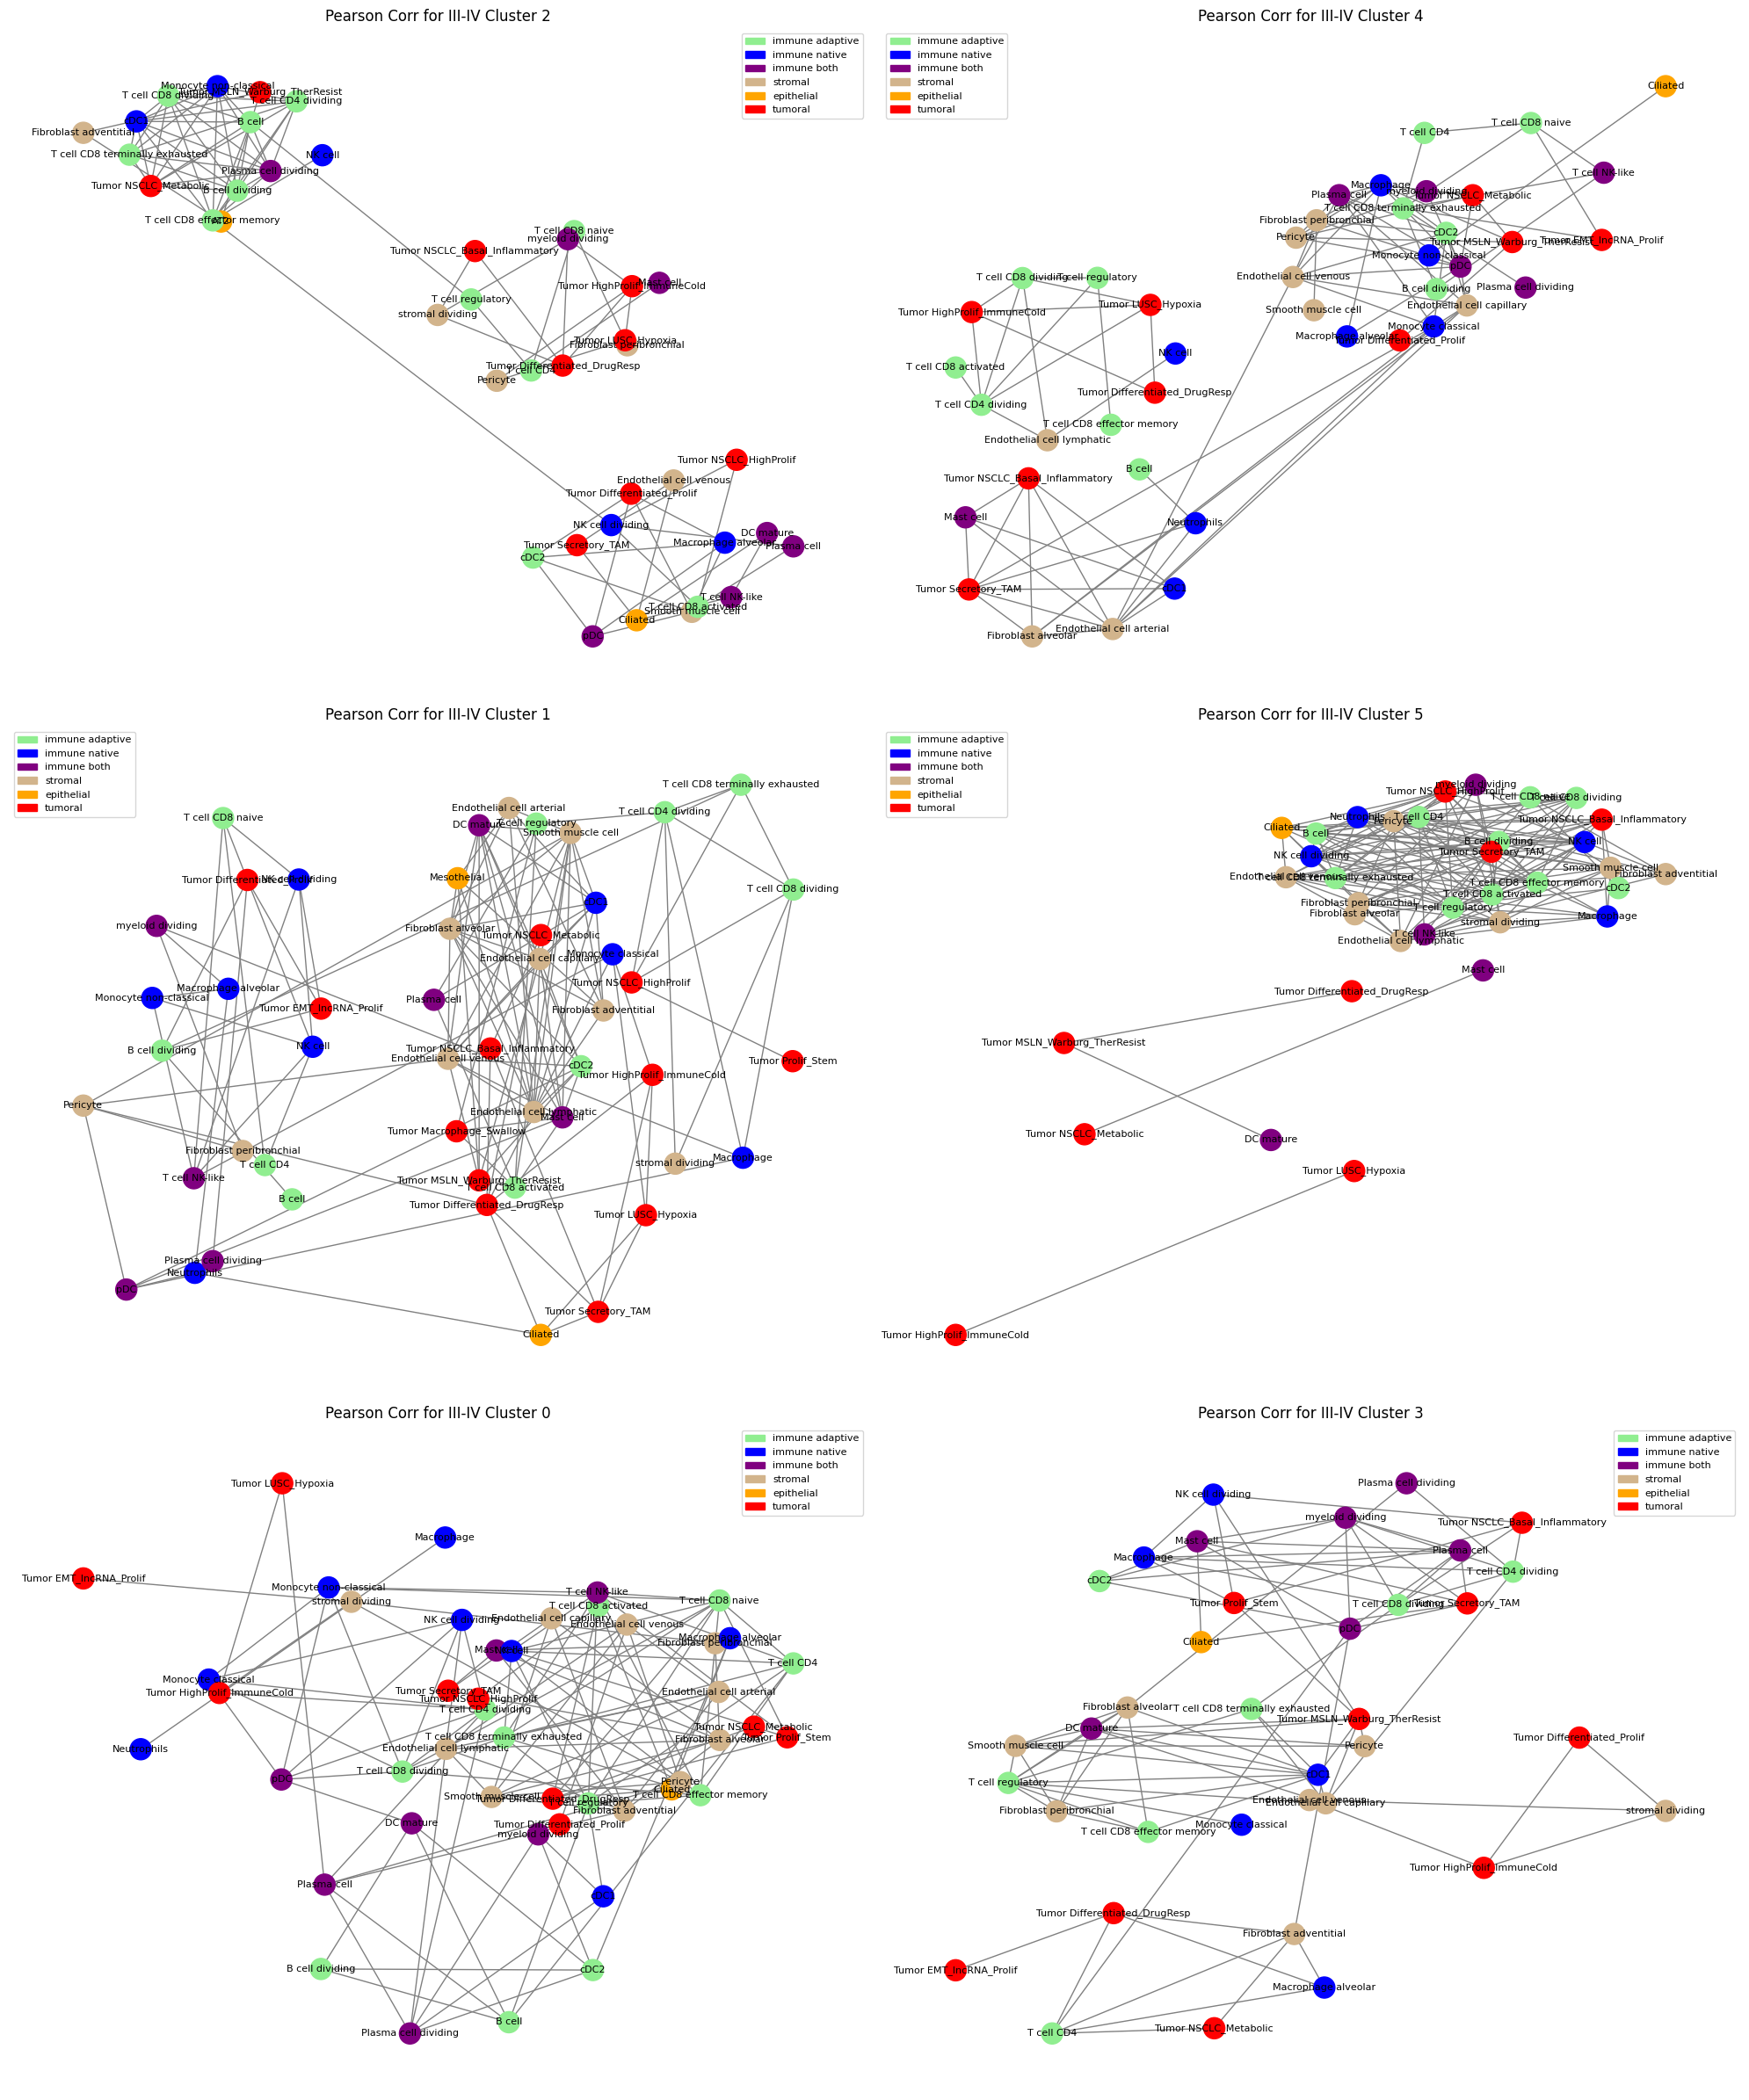

In [ ]:
unique_clusters = corr_types["membership"].unique()
ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8*nrows))
# fig.subplots_adjust(wspace=0.002, hspace=0.02)

for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id]#.drop(columns="membership")

    if cluster_id not in Gs.keys():        
        G = abundance.draw_pearson_graphs(subset, title=time, draw=False)
        Gs[cluster_id] = G
    else:
        G = Gs[cluster_id]

    # # Show the image in a grid cell
    ax = axes[i // ncols, i % ncols]
    abundance.draw_graph(G, ax, f'Pearson Corr for {time_solo} Cluster {cluster_id}', scale2=7, k=3)

plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)
plt.show()


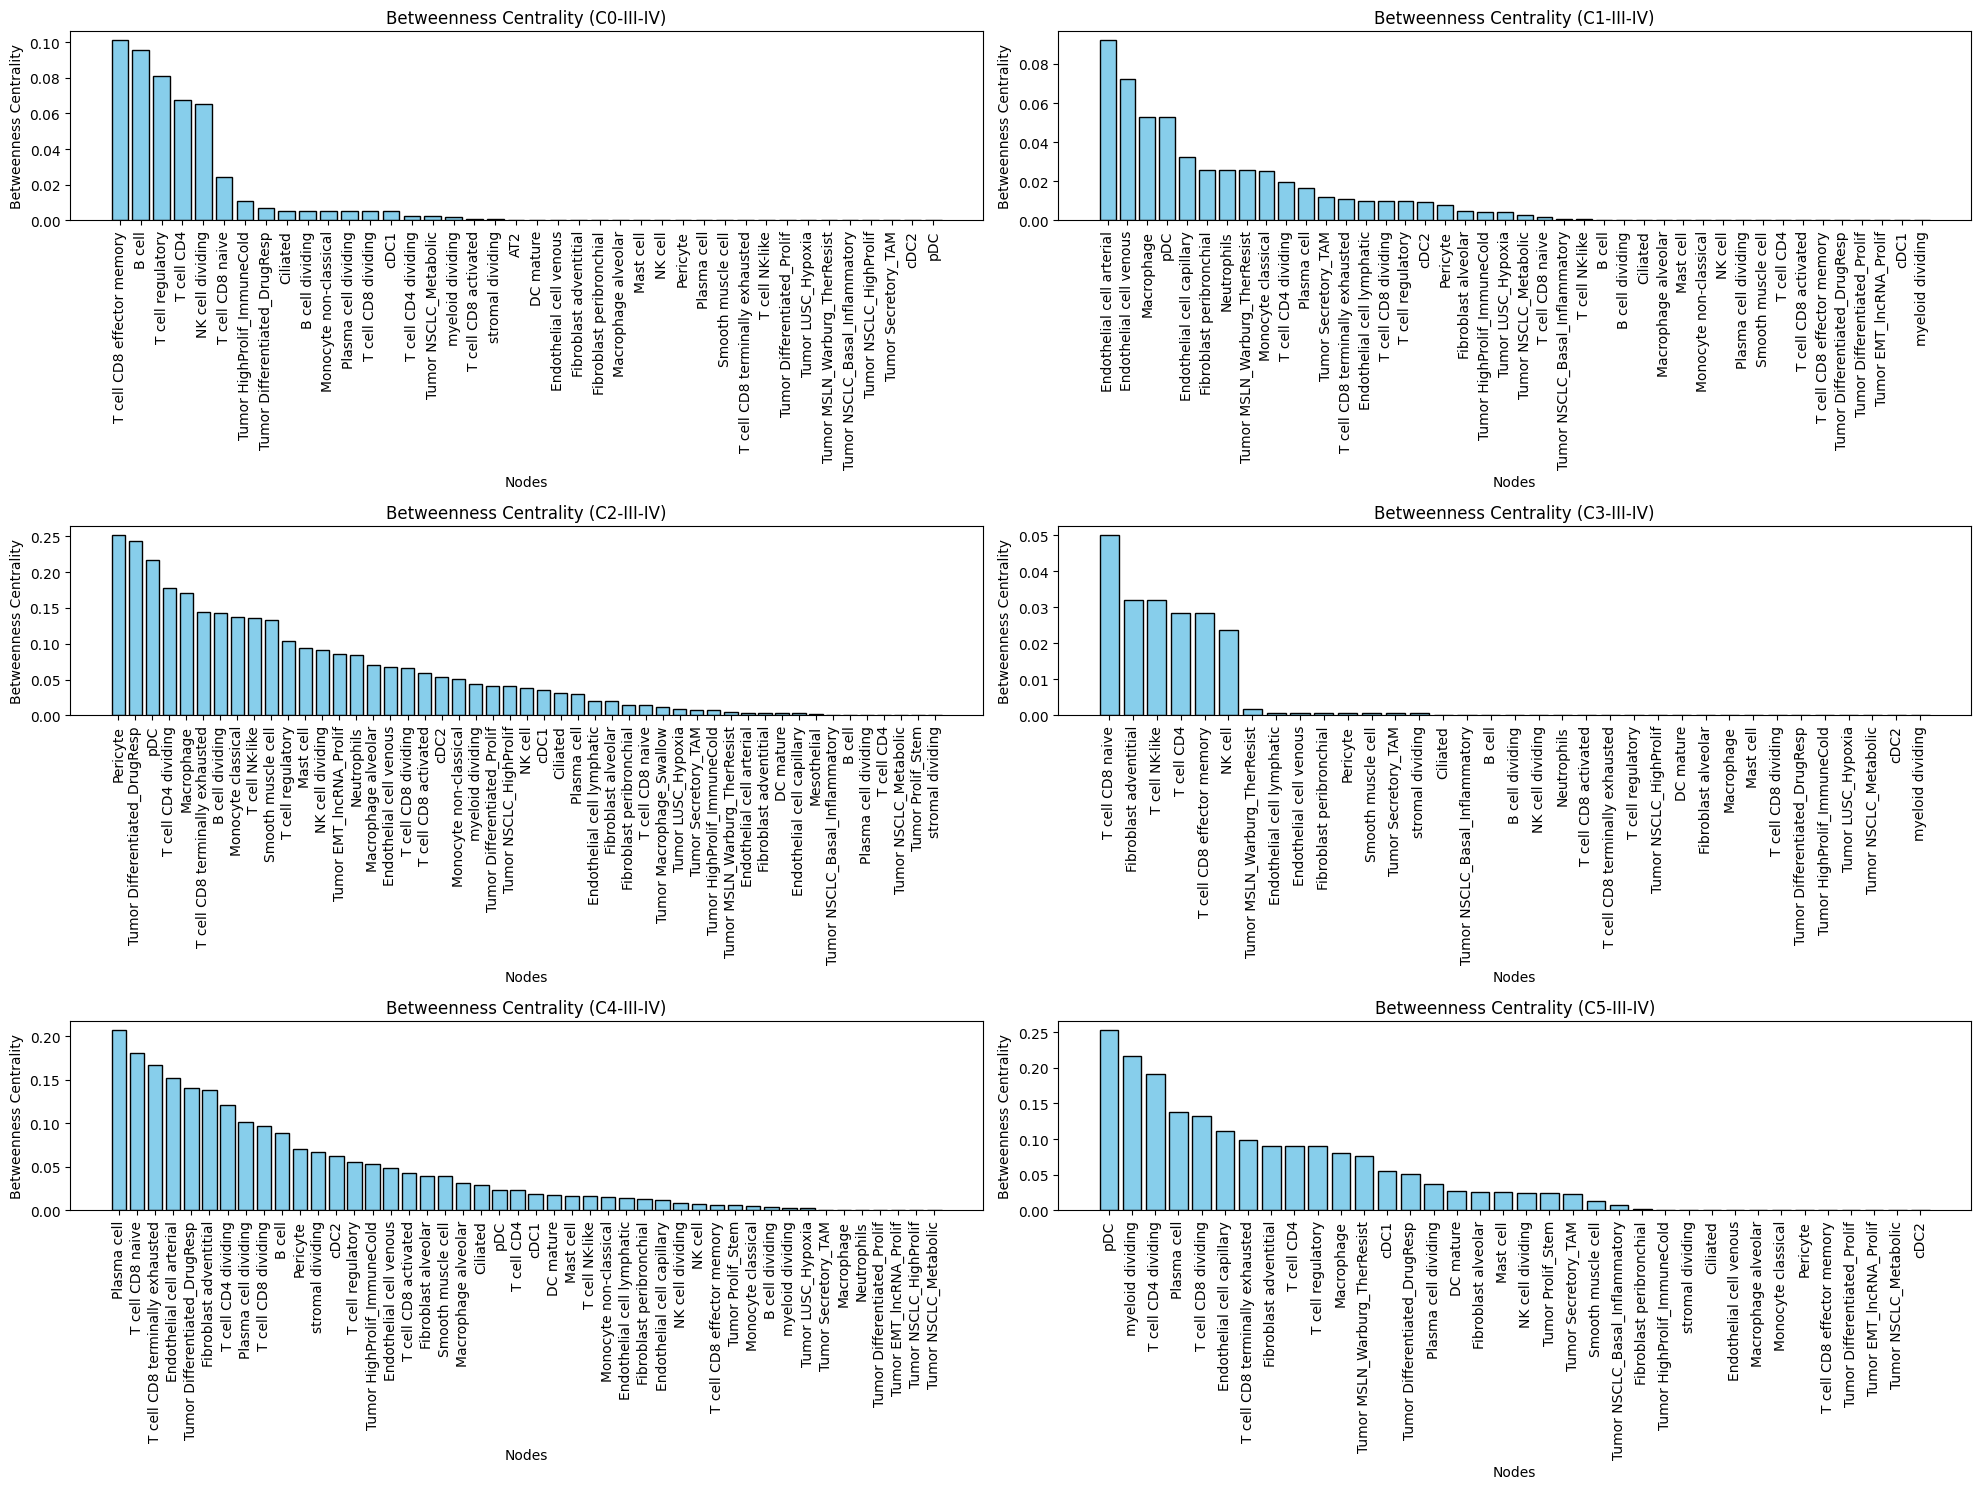

In [212]:
unique_clusters = corr_types["membership"].unique()
ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 5*nrows))
# fig.subplots_adjust(wspace=0.002, hspace=0.02)
for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id]#.drop(columns="membership")

    if cluster_id not in Gs.keys():        
        G = abundance.draw_pearson_graphs(subset, title=time, draw=False)
        Gs[cluster_id] = G
    else:
        G = Gs[cluster_id]
    # # Show the image in a grid cell
    ax = axes[i // ncols, i % ncols]
    abundance.plot_degree_centrality(G, time=f'C{i}-{time_solo}', ax=ax, betweenness=True)
    # abundance.draw_graph(G, ax, f'Pearson Corr for {time_solo} Cluster {cluster_id}', scale2=7, k=3)

plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)
plt.show()


### Sankey Plot

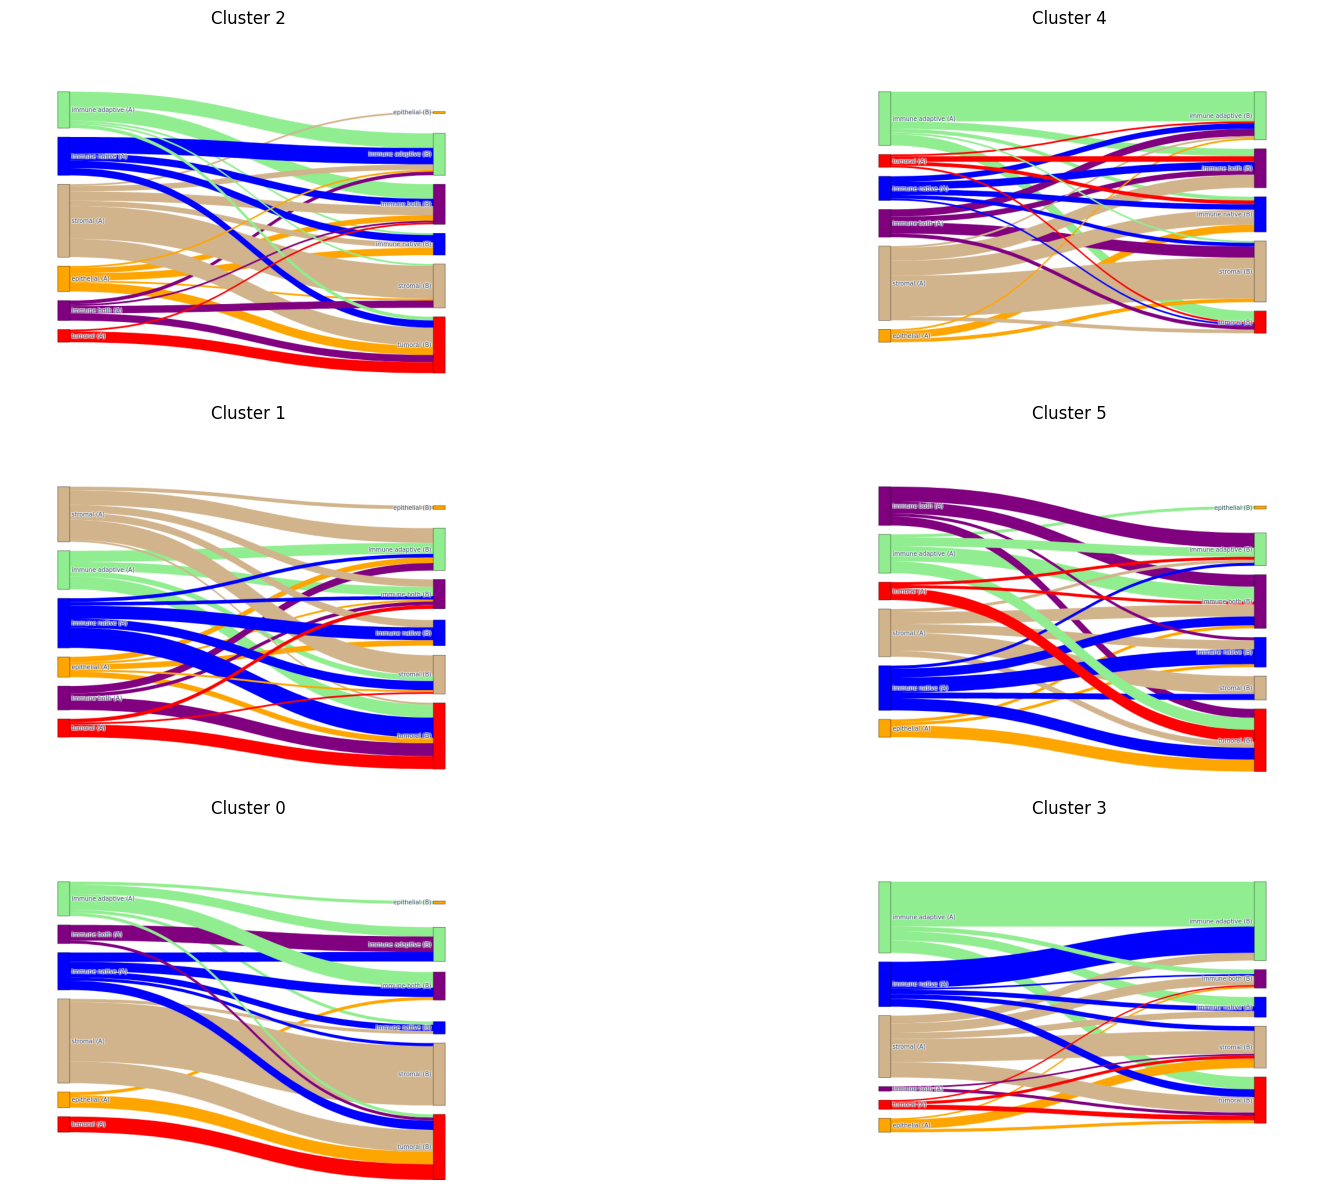

In [ ]:
import io
from PIL import Image

unique_clusters = corr_types["membership"].unique()
ncols = 2
nrows = (len(unique_clusters) + ncols - 1) // ncols
is_unpair = len(unique_clusters) % ncols == 1
nrows2 = nrows -1 if is_unpair else nrows
fig = plt.figure(figsize=(20, 4*nrows))

for i, cluster_id in enumerate(unique_clusters):
    subset = corr_types[corr_types["membership"] == cluster_id].drop(columns="membership")

    if cluster_id not in Gs.keys():        
        G = abundance.draw_pearson_graphs(subset, title=time, draw=False)
        Gs[cluster_id] = G
    else:
        G = Gs[cluster_id]

    temp_fig = abundance.make_sankey_plot(Gs[i], abundance.cell_category_mapping, abundance.color_map)

    # Convert the figure to an image
    buf = io.BytesIO()
    temp_fig.write_image(buf,format="png")
    # temp_fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)

    rs = 2 if is_unpair and i == len(unique_clusters) - 2 else 1
    ax = plt.subplot2grid((nrows, ncols), (i // ncols, i % ncols), rowspan=rs)

    ax.imshow(img)
    ax.set_title(f"Cluster {cluster_id}")
    ax.axis('off')


plt.tight_layout()
plt.show()